In [1]:
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib import pyplot as plt
from scipy import stats
import random
import math
import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

In [63]:
def f(chi):
    return np.sqrt((1+np.sqrt(1-chi**2))/2)
    
def p_f(f):
    return 2*(2*f**2-1)/np.sqrt(1-f**2)

def integral(f,M,mu,sigma):
    return np.exp(-(M/f-mu)**2/(2*sigma**2))/f

def p_M_irr(f,M,mu,sigma,N):
    return np.sqrt(2/np.pi)/2/sigma/N*sum(integral(f,M,mu,sigma))

def kde_sklearn(data, bandwidth, xgrid, kernel="gaussian"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

$M_{irr}=M\sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}=Mf(\chi)$

## Plot the $M_{irr}$ distribution in a histogram

Let's generate a sample for $M_{irr}$ and plot it in a histogram. The histogram will look different depending on the number of bins we choose. We can try to choose bins of variable size with the same number of values in each bin.

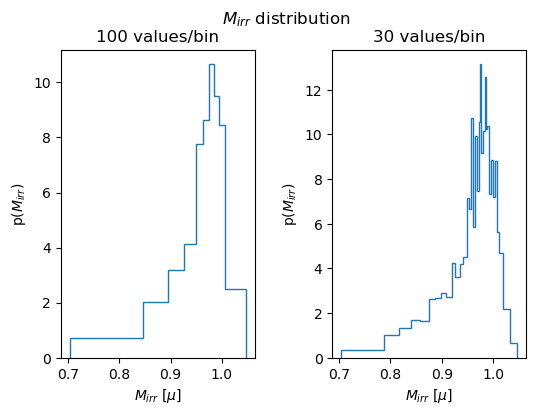

In [29]:
#I generate my distribution
mu = 1
sigma = 0.02
chi = np.random.uniform(0,1,1000)
M = np.random.normal(mu,sigma,1000)
M_irr = M*f(chi)

fig,axes = plt.subplots(1,2,figsize=(6,4))
fig.subplots_adjust(hspace=0.4,wspace=0.4)

#bins with variable width: same number of objects in each bin
bins100 = np.append(np.sort(M_irr)[::100],np.max(M_irr))
axes[0].hist(M_irr,bins100,density=True,histtype="step")
axes[0].set_xlabel(r"$M_{irr}$ [$\mu$]")
axes[0].set_ylabel(r'p($M_{irr}$)')
axes[0].set_title('100 values/bin')

bins30 = np.append(np.sort(M_irr)[::30],np.max(M_irr))
axes[1].hist(M_irr,bins30,density=True,histtype="step")
axes[1].set_xlabel(r"$M_{irr}$ [$\mu$]")
axes[1].set_ylabel(r'p($M_{irr}$)')
axes[1].set_title('30 values/bin')

fig.suptitle('$M_{irr}$ distribution')
plt.show()

## Plot the $M_{irr}$ distribution using a KDE

Let's plot the same distribution using a KDE. Now, the distribution we obtain will look different depending on the bandwidth of the KDE.

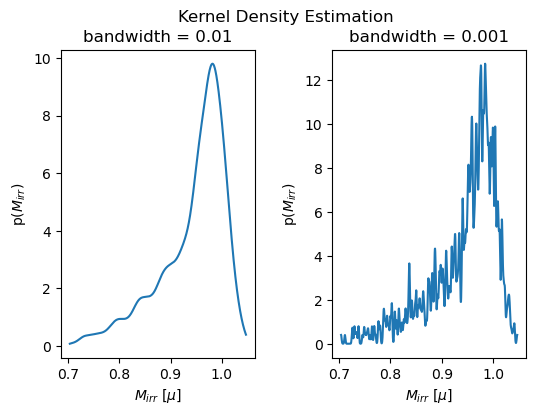

In [32]:
x_plot = np.linspace(np.min(M_irr),np.max(M_irr),1000)
fig,axes = plt.subplots(1,2,figsize=(6,4))
fig.subplots_adjust(hspace=0.4,wspace=0.4)

bandwidth = 0.01
y = kde_sklearn(M_irr,bandwidth,x_plot)
axes[0].plot(x_plot,y)
axes[0].set_title('bandwidth = '+str(bandwidth))
axes[0].set_xlabel(r"$M_{irr}$ [$\mu$]")
axes[0].set_ylabel(r'p($M_{irr}$)')

bandwidth = 0.001
y = kde_sklearn(M_irr,bandwidth,x_plot)
plt.plot(x_plot,y)
axes[1].set_title('bandwidth = '+str(bandwidth))
axes[1].set_xlabel(r"$M_{irr}$ [$\mu$]")
axes[1].set_ylabel(r'p($M_{irr}$)')

fig.suptitle('Kernel Density Estimation')
plt.show()

#bigger number of values in each bin <==> bigger bandwidth
#smaller number of values in each bin <==> smaller bandwidth

## KS distance

Let's compute the KS distance between $M_{irr}/\mu$ and $f$ and between $M_{irr}/\mu$ and $M$ as a function of $\sigma$. This will give us informations about the $M_{irr}$ distribution.

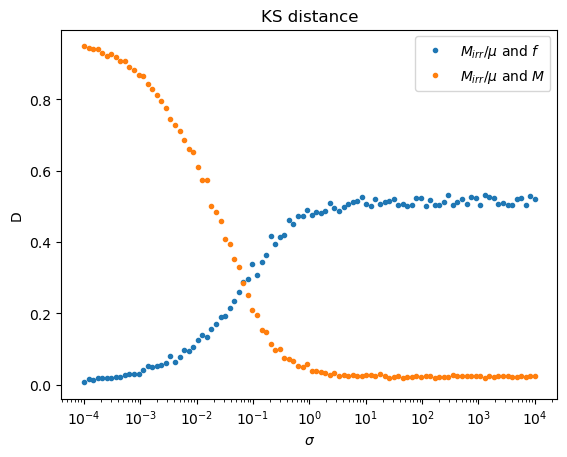

In [45]:
chi = np.random.uniform(0,1,1000)
D_KS_f = []
D_KS_M = []
sigma = np.geomspace(10**(-4),10**4,100)

for i in sigma:
    M = np.random.normal(mu,i,1000)
    M_irr = M*f(chi)
    D_KS_f.append(scipy.stats.ks_2samp(M_irr,f(chi)).statistic)
    D_KS_M.append(scipy.stats.ks_2samp(M_irr,M).statistic)
  
plt.plot(sigma,D_KS_f,'.',label=r'$M_{irr}$/$\mu$ and $f$')
plt.plot(sigma,D_KS_M,'.',label=r'$M_{irr}$/$\mu$ and $M$')
#plt.plot(np.ones(5)*mu,np.linspace(0,1,5),'--',label=r'$\mu$',c='k')
plt.title('KS distance')
plt.xscale('log')
plt.xlabel(r'$\sigma$')
plt.ylabel('D')
plt.legend()
plt.show()

Let's look at the plot: for the $M_{irr}$ vs $M$ case, the KS distance is small for big values of $\sigma$;  for the $M_{irr}$ vs $f$ case, the KS distance is small for small values of $\sigma$. Therefore, we expect $M_{irr}$ to be distributed as $f$ for small values of $\sigma$ and to be distributed as $M$ for big values of $\sigma$

## Analytic distributions of $f$ and $M_{irr}$

Analytic distribution of $f$: $\pi(f)=2\frac{2f^2-1}{\sqrt{1-f^2}}$

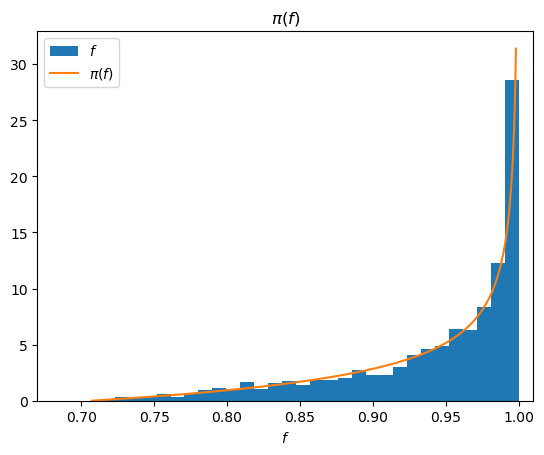

In [53]:
chi = np.random.uniform(0,1,1000)
x_plot = np.linspace(1/math.sqrt(2),0.998,1000)
plt.hist(f(chi),30,density=True,label='$f$')  #sample
plt.plot(x_plot,p_f(x_plot),label=r'$\pi$($f$)')  #analytic distribution
plt.legend()
plt.xlim(0.67,1.01)
plt.title(r'$\pi$($f$)')
plt.xlabel('$f$')
plt.show()

Analytic distribution of $M_{irr}$: $p(M_{irr})=\frac{\sqrt{2/\pi}}{\sigma}\int_{1/\sqrt{2}}^{1}\exp{[-\frac{(M_{irr}/f-\mu)^2)}{2\sigma^2}]}\frac{2f^2-1}{f\sqrt{1-f^2}}\,df$

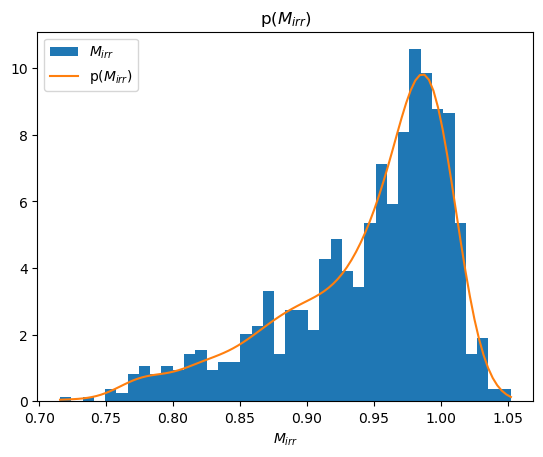

In [67]:
sigma = 0.02
chi = np.random.uniform(0,1,1000)
M = np.random.normal(mu,sigma,1000)
M_irr = M*f(chi)
plt.hist(M_irr,40,density=True,label='$M_{irr}$')  #histogram

#for the integral I use Montecarlo: p(x) is pi(f)
sample = f(chi)
x_plot = np.linspace(np.min(M_irr),np.max(M_irr),100)
pdf = [p_M_irr(sample,i,mu,sigma,len(chi)) for i in x_plot]
plt.plot(x_plot,pdf,label='p($M_{irr}$)')    #analytic distribution

plt.legend()
plt.title('p($M_{irr}$)')
plt.xlabel('$M_{irr}$')
plt.show()

## $M_{irr}$ distribution for different values of $\sigma$

Let's check the limits we obtained by looking at the KDE. We generate two samples of $M_{irr}$, one with $\sigma<<\mu$, the other with $\sigma>>\mu$. We check that the first sample is distributed as $f$ and that the second as $M$.

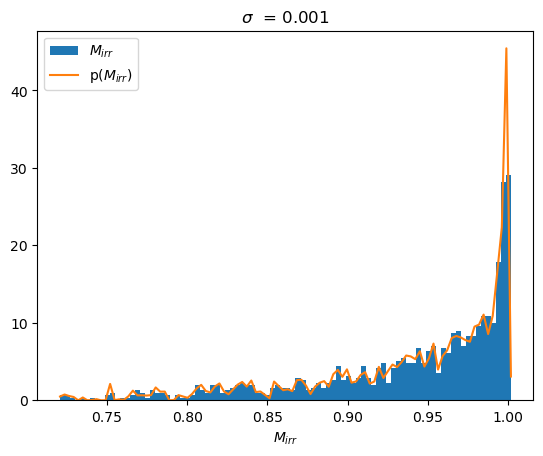

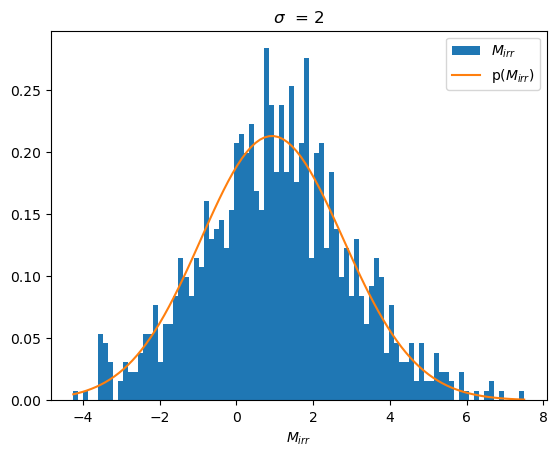

In [70]:
chi = np.random.uniform(0,1,1000)

sigma = 0.001
M = np.random.normal(mu,sigma,1000)
M_irr = M*f(chi)
a,b,c=plt.hist(M_irr,90,density=True,label='$M_{irr}$')
x_plot = np.linspace(np.min(M_irr),np.max(M_irr),100)
pdf = [p_M_irr(f(chi),i,mu,sigma,len(chi)) for i in x_plot]
plt.plot(x_plot,pdf,label='p($M_{irr}$)')
plt.legend()
plt.xlabel('$M_{irr}$')
plt.title(r'$\sigma$  = ' + str(sigma))
plt.show()

sigma = 2
M = np.random.normal(mu,sigma,1000)
M_irr = M*f(chi)
a,b,c=plt.hist(M_irr,90,density=True,label='$M_{irr}$')
x_plot = np.linspace(np.min(M_irr),np.max(M_irr),100)
pdf = [p_M_irr(f(chi),i,mu,sigma,len(chi)) for i in x_plot]
plt.plot(x_plot,pdf,label='p($M_{irr}$)')
plt.legend()
plt.xlabel('$M_{irr}$')
plt.title(r'$\sigma$  = ' + str(sigma))
plt.show()